In [ ]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import torch
import torchsummary as summary
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import OrderedDict

In [ ]:
def load_class_ids(class_file_path):
    """
    Load class ids from class_info.pickle file
    """
    with open(class_file_path, 'rb') as f:
        class_ids = pickle.load(f, encoding='latin1')
        return class_ids

def load_embeddings(embeddings_path):
    """
    Load embeddings
    """
    with open(embeddings_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
        embeddings = np.array(embeddings)
        print('embeddings: ', embeddings.shape)
    return embeddings

def load_filenames(filenames_file_path):
    """
    Load filenames.pickle file and return a list of all file names
    """
    with open(filenames_file_path, 'rb') as f:
        filenames = pickle.load(f, encoding='latin1')
    return filenames

def load_bounding_boxes(dataset_dir):
    """
    Load bounding boxes and return a dictionary of file names and corresponding bounding boxes
    """
    # Paths
    bounding_boxes_path = os.path.join(dataset_dir, 'bounding_boxes.txt')
    file_paths_path = os.path.join(dataset_dir, 'images.txt')

    # Read bounding_boxes.txt and images.txt file
    df_bounding_boxes = pd.read_csv(bounding_boxes_path,
                                    delim_whitespace=True, header=None).astype(int)
    df_file_names = pd.read_csv(file_paths_path, delim_whitespace=True, header=None)

    # Create a list of file names
    file_names = df_file_names[1].tolist()

    # Create a dictionary of file_names and bounding boxes
    filename_boundingbox_dict = {img_file[:-4]: [] for img_file in file_names[:2]}

    # Assign a bounding box to the corresponding image
    for i in range(0, len(file_names)):
        # Get the bounding box
        bounding_box = df_bounding_boxes.iloc[i][1:].tolist()
        key = file_names[i][:-4]
        filename_boundingbox_dict[key] = bounding_box

    return filename_boundingbox_dict

def get_img(img_path, bbox, image_size):
    """
    Load and resize image
    """
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - R)
        y2 = np.minimum(height, center_y + R)
        x1 = np.maximum(0, center_x - R)
        x2 = np.minimum(width, center_x + R)
        img = img.crop([x1, y1, x2, y2])
    img = img.resize(image_size, PIL.Image.BILINEAR)
    return img

def load_dataset(filenames_file_path, class_file_path, cub_dataset_dir, embeddings_path, image_size,types):
    """
    Load dataset
    """
    filenames = load_filenames(filenames_file_path)
    class_ids = load_class_ids(class_file_path)
    bounding_boxes = load_bounding_boxes(cub_dataset_dir)
    all_embeddings = load_embeddings(embeddings_path)

    x, y, embeddings = [], [], []
    count = 0

    print("Embeddings shape:", all_embeddings.shape)

    for index, filename in enumerate(filenames):
        bounding_box = bounding_boxes[filename]
        if count%100==0:
          print("its in data",count)

        try:
            # Load images
            img_name = '{}/images/{}.jpg'.format(cub_dataset_dir, filename)
            img = get_img(img_name, bounding_box, image_size)

            all_embeddings1 = all_embeddings[index, :, :]

            embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
            embedding = all_embeddings1[embedding_ix, :]

            x.append(np.array(img))
            y.append(class_ids[index])
            embeddings.append(embedding)
            count+=1
        except Exception as e:
            print(e)

    x = np.array(x)
    y = np.array(y)
    embeddings = np.array(embeddings)
    np.savez(f'Finalyearproject/Datasets/files/{types}_file.npz',x=x,y=y,embeddings=embeddings)
    print(f'{types} saved')
    return x, y, embeddings

def load_data(types):
  a=np.load(f'Finalyearproject/Datasets/files/{types}_file.npz')
  x,y,embeds = a['x'],a['y'],a['embeddings']
  return x,y,embeds

In [ ]:
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c
def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(1024,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model

def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(1024,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen

def build_stage1_discriminator():
    """
    Create a model which takes two inputs
    1. One from above network
    2. One from the embedding layer
    3. Concatenate along the axis dimension and feed it to the last module which produces final logits
    """
    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4),
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)
    x2 = Activation('tanh')(x2)

    stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis

def build_adversarial_model(gen_model, dis_model):
    input_layer = Input(shape=(1024,))  #text embeddings
    input_layer2 = Input(shape=(100,))  #latent space
    input_layer3 = Input(shape=(4, 4, 128)) #real image

    x, mean_logsigma = gen_model([input_layer, input_layer2]) #genrated image and some error

    dis_model.trainable = False
    valid = dis_model([x, input_layer3]) #generatedimage,realimage

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model

In [ ]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss


def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)

In [ ]:
def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    print(img.max(),img.min())
    # img = (img-img.min())/(img.max()-img.min())
    # img = img+125.5
    image = Image.fromarray(img,'RGB')
    image.show()
    # time.sleep(3)
    image.save('/content/sample_data/temp1.jpeg')
    ax.imshow(img)
    print(img.max(),img.min())
    # time.sleep(3)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


finished
all models loaded
Epoch is: 100
Number of batches 138
Batch:1
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883556365966797, 13.882453918457031, 0.0005509856273420155]
Saving image
0.9999672 -0.99926925


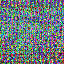

0.9999672 -0.99926925
Saving image
0.9999417 -0.9995473


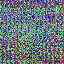

0.9999417 -0.9995473
Saving image
0.99998164 -0.99960935


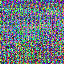

0.99998164 -0.99960935
Saving image
0.9999911 -0.99941146


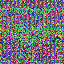

0.9999911 -0.99941146
Saving image
0.9999933 -0.99965805


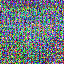

0.9999933 -0.99965805
Saving image
0.99997956 -0.99885696


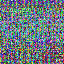

0.99997956 -0.99885696
Saving image
0.99997836 -0.99943507


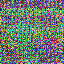

0.99997836 -0.99943507
Saving image
0.9999927 -0.9988615


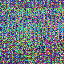

0.9999927 -0.9988615
Saving image
0.99999195 -0.99928063


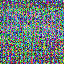

0.99999195 -0.99928063
Saving image
0.99996984 -0.9993928


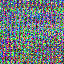

0.99996984 -0.9993928
Batch:2
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882970809936523, 13.882453918457031, 0.0002584160538390279]
Batch:3
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883186340332031, 13.882453918457031, 0.0003662998497020453]
Batch:4
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.8831205368042, 13.882453918457031, 0.0003334097855258733]
Batch:5
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882874488830566, 13.882453918457031, 0.0002104562008753419]
Batch:6
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883293151855469, 13.882453918457031, 0.00041968864388763905]
Batch:7
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883112907409668, 13.88245391845

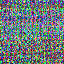

0.9999718 -0.9997596
Saving image
0.99992955 -0.9996024


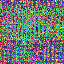

0.99992955 -0.9996024
Saving image
0.999992 -0.9992357


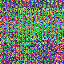

0.999992 -0.9992357
Saving image
0.99998057 -0.99922407


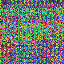

0.99998057 -0.99922407
Saving image
0.9999966 -0.99950016


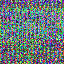

0.9999966 -0.99950016
Saving image
0.999967 -0.9994892


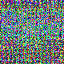

0.999967 -0.9994892
Saving image
0.99999696 -0.9997086


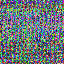

0.99999696 -0.9997086
Saving image
0.9999684 -0.9995484


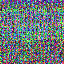

0.9999684 -0.9995484
Saving image
0.9999965 -0.9992586


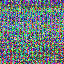

0.9999965 -0.9992586
Saving image
0.9999772 -0.99967605


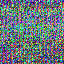

0.9999772 -0.99967605
Batch:22
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882713317871094, 13.882453918457031, 0.0001298632414545864]
Batch:23
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.8826904296875, 13.882453918457031, 0.00011849134898511693]
Batch:24
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883269309997559, 13.882453918457031, 0.00040756823727861047]
Batch:25
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883146286010742, 13.882453918457031, 0.000346060172887519]
Batch:26
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882807731628418, 13.882453918457031, 0.00017706723883748055]
Batch:27
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882905006408691, 13.8824

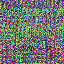

0.9999948 -0.99976116
Saving image
0.9999362 -0.99930334


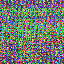

0.9999362 -0.99930334
Saving image
0.9999925 -0.9998883


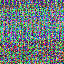

0.9999925 -0.9998883
Saving image
0.99998856 -0.99957407


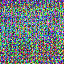

0.99998856 -0.99957407
Saving image
0.999971 -0.9993906


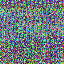

0.999971 -0.9993906
Saving image
0.99998367 -0.99921477


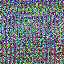

0.99998367 -0.99921477
Saving image
0.9999136 -0.9993888


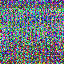

0.9999136 -0.9993888
Saving image
0.99999714 -0.9994006


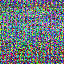

0.99999714 -0.9994006
Saving image
0.99996465 -0.9997589


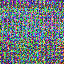

0.99996465 -0.9997589
Saving image
0.9999568 -0.99957037


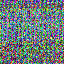

0.9999568 -0.99957037
Batch:42
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.88278865814209, 13.882453918457031, 0.00016728699847590178]
Batch:43
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882706642150879, 13.882453918457031, 0.00012655163300223649]
Batch:44
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882770538330078, 13.882453918457031, 0.00015812457422725856]
Batch:45
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882948875427246, 13.882453918457031, 0.0002476207446306944]
Batch:46
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883089065551758, 13.882453918457031, 0.0003175997990183532]
Batch:47
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882916450500488, 13.88

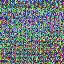

0.99997324 -0.99792856
Saving image
0.999988 -0.9989023


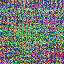

0.999988 -0.9989023
Saving image
0.9999614 -0.9989109


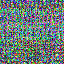

0.9999614 -0.9989109
Saving image
0.9999733 -0.99918336


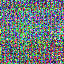

0.9999733 -0.99918336
Saving image
0.99998736 -0.99899286


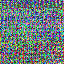

0.99998736 -0.99899286
Saving image
0.9999736 -0.9988416


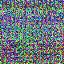

0.9999736 -0.9988416
Saving image
0.9999695 -0.9986525


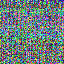

0.9999695 -0.9986525
Saving image
0.9999853 -0.9992967


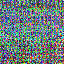

0.9999853 -0.9992967
Saving image
0.9999956 -0.99834806


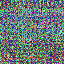

0.9999956 -0.99834806
Saving image
0.99996555 -0.99960285


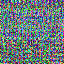

0.99996555 -0.99960285
Batch:62
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882702827453613, 13.882453918457031, 0.00012451494694687426]
Batch:63
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.88282299041748, 13.882453918457031, 0.0001846951199695468]
Batch:64
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882898330688477, 13.882453918457031, 0.00022239997633732855]
Batch:65
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883031845092773, 13.882453918457031, 0.0002887286536861211]
Batch:66
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883028030395508, 13.882453918457031, 0.0002869370218832046]
Batch:67
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882851600646973, 13.88

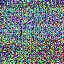

0.99998486 -0.99932104
Saving image
0.9999746 -0.99946123


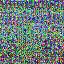

0.9999746 -0.99946123
Saving image
0.99997336 -0.99947673


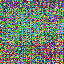

0.99997336 -0.99947673
Saving image
0.99995327 -0.99869424


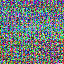

0.99995327 -0.99869424
Saving image
0.99997425 -0.99836624


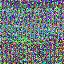

0.99997425 -0.99836624
Saving image
0.99994737 -0.9996145


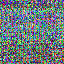

0.99994737 -0.9996145
Saving image
0.99997646 -0.99907655


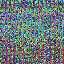

0.99997646 -0.99907655
Saving image
0.9999809 -0.9996802


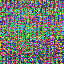

0.9999809 -0.9996802
Saving image
0.9999582 -0.99920243


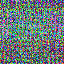

0.9999582 -0.99920243
Saving image
0.99998105 -0.99908435


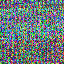

0.99998105 -0.99908435
Batch:82
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882561683654785, 13.882453918457031, 5.3683215810451657e-05]
Batch:83
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.88254165649414, 13.882453918457031, 4.398834425956011e-05]
Batch:84
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882556915283203, 13.882453918457031, 5.151119694346562e-05]
Batch:85
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882545471191406, 13.882453918457031, 4.589757736539468e-05]
Batch:86
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.882545471191406, 13.882453918457031, 4.557053398457356e-05]
Batch:87
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.88254451751709, 13.8824

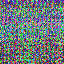

0.99998873 -0.9997788
Saving image
0.99997705 -0.99945134


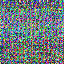

0.99997705 -0.99945134
Saving image
0.9999596 -0.99940526


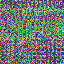

0.9999596 -0.99940526
Saving image
0.99998516 -0.99970514


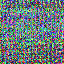

0.99998516 -0.99970514
Saving image
0.9999929 -0.9993003


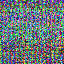

0.9999929 -0.9993003
Saving image
0.999989 -0.9995239


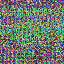

0.999989 -0.9995239
Saving image
0.99997824 -0.99971265


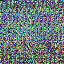

0.99997824 -0.99971265
Saving image
0.9999936 -0.9996907


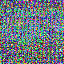

0.9999936 -0.9996907
Saving image
0.99999416 -0.999707


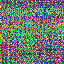

0.99999416 -0.999707
Saving image
0.99998325 -0.9996033


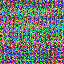

0.99998325 -0.9996033
Batch:102
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.884048461914062, 13.882453918457031, 0.0007972780149430037]
Batch:103
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883484840393066, 13.882453918457031, 0.0005156835541129112]
Batch:104
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883312225341797, 13.882453918457031, 0.0004290142096579075]
Batch:105
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883255958557129, 13.882453918457031, 0.0004012556455563754]
Batch:106
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883180618286133, 13.882453918457031, 0.0003634776803664863]
Batch:107
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.883427619934082, 1

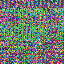

0.99995196 -0.99918264
Saving image
0.99997765 -0.99926764


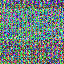

0.99997765 -0.99926764
Saving image
0.9999797 -0.99941444


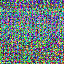

0.9999797 -0.99941444
Saving image
0.99996716 -0.99899626


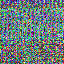

0.99996716 -0.99899626
Saving image
0.9999948 -0.99941283


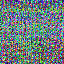

0.9999948 -0.99941283
Saving image
0.99998707 -0.9989163


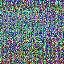

0.99998707 -0.9989163
Saving image
0.9999812 -0.9979091


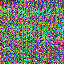

0.9999812 -0.9979091
Saving image
0.99999183 -0.99962


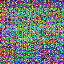

0.99999183 -0.99962
Saving image
0.999985 -0.9991645


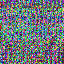

0.999985 -0.9991645
Saving image
0.99998146 -0.9991942


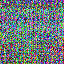

0.99998146 -0.9991942
Batch:122
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.888164520263672, 13.882453918457031, 0.002855236642062664]
Batch:123
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.886910438537598, 13.882453918457031, 0.0022280318662524223]
Batch:124
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.885866165161133, 13.882453918457031, 0.0017062305705621839]
Batch:125
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.887484550476074, 13.882453918457031, 0.002515400294214487]
Batch:126
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.885839462280273, 13.882453918457031, 0.0016925904201343656]
Batch:127
d_loss_real:13.882453918457031
d_loss_fake:0.0
d_loss_wrong:0.0
d_loss:6.941226959228516
g_loss:[13.886611938476562, 13.

In [ ]:
if __name__ == '__main__':
    data_dir = "Finalyearproject/Datasets/birds/birds"
    start = 100
    resume = True
    train_dir = data_dir + "/train"
    test_dir = data_dir + "/test"
    image_size = 64
    batch_size = 64
    z_dim = 100
    stage1_generator_lr = 0.002
    stage1_discriminator_lr = 0.002
    stage1_lr_decay_step = 600
    epochs = 201
    condition_dim = 128

    embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
    embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"

    filenames_file_path_train = train_dir + "/filenames.pickle"
    filenames_file_path_test = test_dir + "/filenames.pickle"

    class_file_path_train = train_dir + "/class_info.pickle"
    class_file_path_test = test_dir + "/class_info.pickle"

    cub_dataset_dir = "Finalyearproject/Datasets/CUB_200_2011/CUB_200_2011"

    # Define optimizers
    dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

    """"
    Load datasets
    """
    # X_train, y_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
    #                                                   class_file_path=class_file_path_train,
    #                                                   cub_dataset_dir=cub_dataset_dir,
    #                                                   embeddings_path=embeddings_path_train,
    #                                                   image_size=(64, 64),types='train')

    # X_test, y_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
    #                                                class_file_path=class_file_path_test,
    #                                                cub_dataset_dir=cub_dataset_dir,
    #                                                embeddings_path=embeddings_path_test,
    #                                                image_size=(64, 64),types='test')

    X_train,y_train,embeddings_train = load_data(types='train')
    X_test,y_test,embeddings_test = load_data(types='test')
    print("finished")

    """
    Build and compile networks
    """
    # ca_model = build_ca_model()
    # ca_model.compile(loss="binary_crossentropy", optimizer="adam")

    # stage1_dis = build_stage1_discriminator()
    # stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    # stage1_gen = build_stage1_generator()
    # stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

    # embedding_compressor_model = build_embedding_compressor_model()
    # embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

    # adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
    # adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
    #                           optimizer=gen_optimizer, metrics=None)
    if resume==False:
      ca_model = build_ca_model()
      ca_model.compile(loss="binary_crossentropy", optimizer="adam")

      stage1_dis = build_stage1_discriminator()
      stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

      stage1_gen = build_stage1_generator()
      stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

      embedding_compressor_model = build_embedding_compressor_model()
      embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

      adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
      adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                                optimizer=gen_optimizer, metrics=None)

    else:
      ca_model = build_ca_model()
      ca_model.compile(loss="binary_crossentropy", optimizer="adam")

      stage1_dis = build_stage1_discriminator()
      stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

      stage1_gen = build_stage1_generator()
      stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

      embedding_compressor_model = build_embedding_compressor_model()
      embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

      adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
      adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                                optimizer=gen_optimizer, metrics=None)
      ca_model.load_weights('Finalyearproject/Datasets/results_3/part1/stage1_ca.h5')
      stage1_dis.load_weights('Finalyearproject/Datasets/results_3/part1/stage1_discrimator.h5')
      stage1_gen.load_weights('Finalyearproject/Datasets/results_3/stage1_generator.h5')
      embedding_compressor_model.load_weights('Finalyearproject/Datasets/results_3/embedding_compressor.h5')
      adversarial_model.load_weights('Finalyearproject/Datasets/results_3/part1/adversarial_model.h5')
      print("all models loaded")

    # tensorboard = TensorBoard(log_dir="Finalyearproject/Datasets/logs1".format(time.time()))
    # tensorboard.set_model(stage1_gen)
    # tensorboard.set_model(stage1_dis)
    # tensorboard.set_model(ca_model)
    # tensorboard.set_model(embedding_compressor_model)

    # Generate an array containing real and fake values
    # Apply label smoothing as well
    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(start,epochs):
        print("========================================")
        print("Epoch is:", epoch)
        print("Number of batches", int(X_train.shape[0] / batch_size))

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_train.shape[0] / batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))

            """
            Train the discriminator network
            """
            # Sample a batch of data
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
            image_batch = (image_batch - 127.5) / 127.5 # makes the image darker and gets it in range -1 to 1

            # Generate fake images
            fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)

            # Generate compressed embeddings
            compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch) #converts the 1024 size to much more less i.e 128
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim)) #-1 is whatever size should be calculated by numpy itself
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

            dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))

            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))

            """
            Train the generator network
            """
            g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

            """
            Save losses to Tensorboard after each epoch
            """
            # write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
            # write_log(tensorboard, 'generator_loss', np.mean(gen_losses[0]), epoch)

            # Generate and save images after every 2nd epoch
            if epoch % 5 == 0 and index%20==0:
                # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
                embedding_batch = embeddings_test[0:batch_size]
                fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

                # Save images
                for i, img in enumerate(fake_images[:10]):
                  print("Saving image")
                  save_rgb_img(img, "Finalyearproject/Datasets/results_3/gen_{}_{}.png".format(epoch, i))
                stage1_gen.save_weights('Finalyearproject/Datasets/results_3/part1/stage1_generator.h5')
                stage1_dis.save_weights('Finalyearproject/Datasets/results_3/part1/stage1_discrimator.h5')
                ca_model.save_weights('Finalyearproject/Datasets/results_3/part1/stage1_ca.h5')
                embedding_compressor_model.save_weights('Finalyearproject/Datasets/results_3/part1/embedding_compressor.h5')
                adversarial_model.save_weights('Finalyearproject/Datasets/results_3/part1/adversarial_model.h5')


    # Save models
    stage1_gen.save_weights("Finalyearproject/Datasets/weights_3/part1/stage1_gen.h5")
    stage1_dis.save_weights("Finalyearproject/Datasets/weights_3/part1/stage1_dis.h5")

In [ ]:
model = torch.load('Finalyearproject/model/model_3.pth',map_location=torch.device('cpu'))

#Class for the Model

In [ ]:
class GLU(nn.Module):
    def __init__(self):
        super(GLU, self).__init__()

    def forward(self, x):
        nc = x.size(1)
        assert nc % 2 == 0, 'channels dont divide 2!'
        nc = int(nc/2)
        return x[:, :nc] * F.sigmoid(x[:, nc:])


def conv3x3(in_planes, out_planes):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                     padding=1, bias=False)

def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes * 2),
        nn.BatchNorm2d(out_planes * 2),
        GLU()
    )
    return block


# Keep the spatial size
def Block3x3_relu(in_planes, out_planes):
    block = nn.Sequential(
        conv3x3(in_planes, out_planes * 2),
        nn.BatchNorm2d(out_planes * 2),
        GLU()
    )
    return block


class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num * 2),
            nn.BatchNorm2d(channel_num * 2),
            GLU(),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num)
        )


    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return out
class INIT_STAGE_G(nn.Module):
    def __init__(self, ngf):
        super(INIT_STAGE_G, self).__init__()
        self.gf_dim = ngf
        condition = True
        if condition:
            self.in_dim = 100 + 128
        else:
            self.in_dim = 100
        self.define_module()

    def define_module(self):
        in_dim = self.in_dim
        ngf = self.gf_dim
        self.fc = nn.Sequential(
            nn.Linear(in_dim, ngf * 4 * 4 * 2, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4 * 2),
            GLU())


        self.upsample1 = upBlock(ngf, ngf // 2)
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        self.upsample3 = upBlock(ngf // 4, ngf // 8)
        self.upsample4 = upBlock(ngf // 8, ngf // 16)

    def forward(self, z_code, c_code=None):
        condition=True
        if condition and c_code is not None:
            in_code = torch.cat((c_code, z_code), 1)
        else:
            in_code = z_code
        # state size 16ngf x 4 x 4
        out_code = self.fc(in_code)
        out_code = out_code.view(-1, self.gf_dim, 4, 4)
        # state size 8ngf x 8 x 8
        out_code = self.upsample1(out_code)
        # state size 4ngf x 16 x 16
        out_code = self.upsample2(out_code)
        # state size 2ngf x 32 x 32
        out_code = self.upsample3(out_code)
        # state size ngf x 64 x 64
        out_code = self.upsample4(out_code)

        return out_code


class NEXT_STAGE_G(nn.Module):
    def __init__(self, ngf, num_residual=2):
        super(NEXT_STAGE_G, self).__init__()
        self.gf_dim = ngf
        condition=True
        if condition:
            self.ef_dim = 128
        else:
            self.ef_dim = 100
        self.num_residual = num_residual
        self.define_module()

    def _make_layer(self, block, channel_num):
        layers = []
        for i in range(self.num_residual):
            layers.append(block(channel_num))
        return nn.Sequential(*layers)

    def define_module(self):
        ngf = self.gf_dim
        efg = self.ef_dim

        self.jointConv = Block3x3_relu(ngf + efg, ngf)
        self.residual = self._make_layer(ResBlock, ngf)
        self.upsample = upBlock(ngf, ngf // 2)
        # self.upsample1 = upBlock(ngf//2,ngf//4)
        # self.upsample2 = upBlock(ngf//4,ngf//8)
        # self.upsample3 = upBlock(ngf//8,ngf//16)
        # self.upsample4 = upBlock(ngf//16,ngf//32)


    def forward(self, h_code, c_code):
        s_size = h_code.size(2)
        c_code = c_code.view(-1, self.ef_dim, 1, 1)
        c_code = c_code.repeat(1, 1, s_size, s_size)
        # state size (ngf+egf) x in_size x in_size
        h_c_code = torch.cat((c_code, h_code), 1)
        # state size ngf x in_size x in_size
        out_code = self.jointConv(h_c_code)
        out_code = self.residual(out_code)
        # state size ngf/2 x 2in_size x 2in_size
        out_code = self.upsample(out_code)
        # out_code = self.upsample1(out_code)
        # out_code = self.upsample2(out_code)
        # out_code = self.upsample3(out_code)
        # out_code = self.upsample4(out_code)

        return out_code
class GET_IMAGE_G(nn.Module):
    def __init__(self, ngf):
        super(GET_IMAGE_G, self).__init__()
        self.gf_dim = ngf
        self.img = nn.Sequential(
            conv3x3(ngf, 3),
            nn.Tanh()
        )

    def forward(self, h_code):
        out_img = self.img(h_code)
        return out_img
class CA_NET(nn.Module):
    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = 1024
        self.ef_dim = 128
        self.fc = nn.Linear(self.t_dim, self.ef_dim * 4, bias=True)
        self.relu = GLU()

    def encode(self, text_embedding):
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :self.ef_dim]
        logvar = x[:, self.ef_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        cuda =False
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, text_embedding):
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar
class G_NET(nn.Module):
    def __init__(self):
        super(G_NET, self).__init__()
        self.gf_dim = 64
        self.define_module()

    def define_module(self):
        condition=True
        if condition:
            self.ca_net = CA_NET() # returns shape of 1024,512
        tree_num = 3
        if tree_num > 0:
            self.h_net1 = INIT_STAGE_G(self.gf_dim * 16)
            self.img_net1 = GET_IMAGE_G(self.gf_dim)
        if tree_num > 1:
            self.h_net2 = NEXT_STAGE_G(self.gf_dim)
            self.img_net2 = GET_IMAGE_G(self.gf_dim // 2)
        if tree_num > 2:
            self.h_net3 = NEXT_STAGE_G(self.gf_dim // 2)
            self.img_net3 = GET_IMAGE_G(self.gf_dim // 4)
        if tree_num > 3: # Recommended structure (mainly limited by GPU memory), and not test yet
            self.h_net4 = NEXT_STAGE_G(self.gf_dim // 4, num_residual=1)
            self.img_net4 = GET_IMAGE_G(self.gf_dim // 8)
        if tree_num > 4:
            self.h_net4 = NEXT_STAGE_G(self.gf_dim // 8, num_residual=1)
            self.img_net4 = GET_IMAGE_G(self.gf_dim // 16)

    def forward(self, z_code, text_embedding=None):
        condition=True
        if condition and text_embedding is not None:
            c_code, mu, logvar = self.ca_net(text_embedding)
        else:
            c_code, mu, logvar = z_code, None, None
        fake_imgs = []
        tree_num= 3
        if tree_num > 0:
            h_code1 = self.h_net1(z_code, c_code)
            fake_img1 = self.img_net1(h_code1)
            print(fake_img1.shape)
            # fake_imgs.append(fake_img1)
        if tree_num > 1:
            h_code2 = self.h_net2(h_code1, c_code)
            fake_img2 = self.img_net2(h_code2)
            fake_imgs.append(fake_img2)
        if tree_num > 2:
            h_code3 = self.h_net3(h_code2, c_code)
            fake_img3 = self.img_net3(h_code3)
            fake_imgs.append(fake_img3)
        if tree_num > 3:
            h_code4 = self.h_net4(h_code3, c_code)
            fake_img4 = self.img_net4(h_code4)
            fake_imgs.append(fake_img4)

        return fake_img1, mu, logvar

#Generating Image

In [ ]:
gen1 = G_NET()
gen1.load_state_dict(model)
print(gen1)

G_NET(
  (ca_net): CA_NET(
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (relu): GLU()
  )
  (h_net1): INIT_STAGE_G(
    (fc): Sequential(
      (0): Linear(in_features=228, out_features=32768, bias=False)
      (1): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GLU()
    )
    (upsample1): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): GLU()
    )
    (upsample2): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): GLU()
    )
    (upsample3): Sequential(
      (0): Upsample(scale_factor=2.0, mode='n

In [ ]:
a = np.load('Finalyearproject/Datasets/files_2/embeds.npy')
print(a.shape)

(2933, 10, 1024)


In [ ]:
from PIL import Image
# i,index = 1,0
noise = Variable(torch.FloatTensor(1, 100))
gen1.eval()
noise.data.normal_(0,1)
# embeds = Variable(torch.tensor(a))
# x = embeds[i-1:i,0:1,:]
x = x[index]
fake_imgs, _, _ = gen1(noise,x)
for i in range(fake_imgs.size(0)):
            fullpath = f'temp{i}.png'
            # range from [-1, 1] to [0, 1]
            img = (fake_imgs[i] + 1.0) / 2
            img = fake_imgs[i].add(1).div(2).mul(255).clamp(0, 255).byte()
            # range from [0, 1] to [0, 255]
            ndarr = img.permute(1, 2, 0).data.cpu().numpy()
            im = Image.fromarray(ndarr)
            im.save(fullpath)

torch.Size([1, 3, 64, 64])
